## [Cell 1] 라이브러리 로드 & 설정

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")


## [Cell 2] 데이터 로드 & 전처리

In [33]:
import os
import pandas as pd

BASE_DIR = os.getcwd()          # notebooks 폴더
DATA_PATH = os.path.join(
    BASE_DIR,
    "..", "data", "01_raw", "train.csv"
)

df = pd.read_csv(DATA_PATH)
df.head()



,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


## [Cell 3] 전체 이탈 분포 (Churn Distribution)

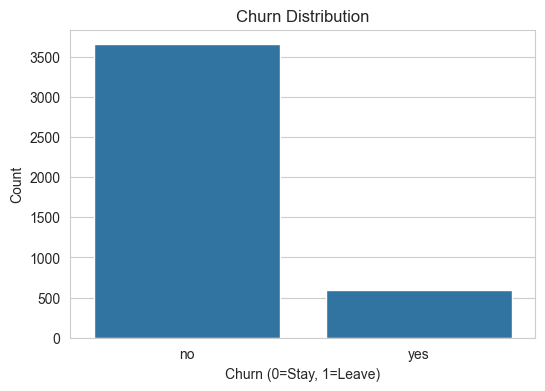

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0=Stay, 1=Leave)')
plt.ylabel('Count')
plt.show()


## 고객센터 통화 횟수 vs 이탈

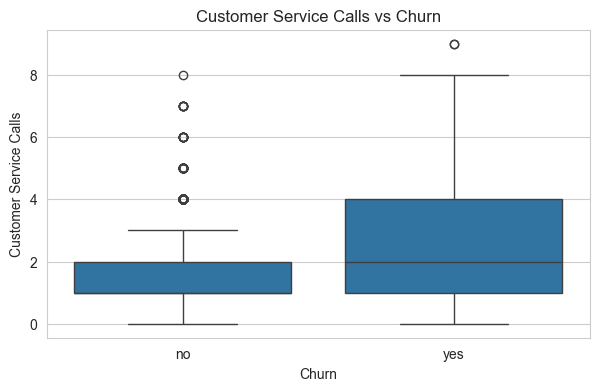

In [35]:
plt.figure(figsize=(7,4))
sns.boxplot(
    x='churn',
    y='number_customer_service_calls',
    data=df
)
plt.title('Customer Service Calls vs Churn')
plt.xlabel('Churn')
plt.ylabel('Customer Service Calls')
plt.show()


## 고객센터 통화 횟수별 평균 이탈률

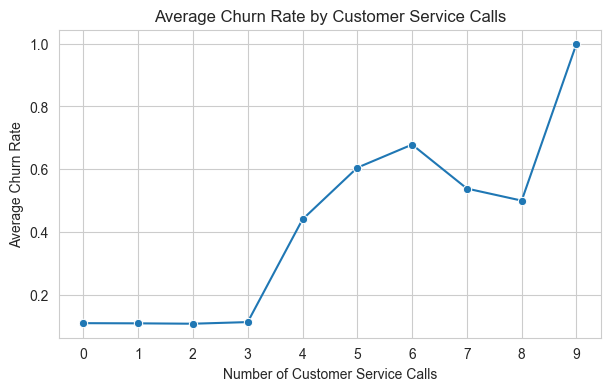

In [36]:
# =========================================================
# 고객센터 통화 횟수별 평균 이탈률
# (dtype 오류 방지 안정화 버전)
# =========================================================

# 1️⃣ churn 컬럼 타입 방어 (가장 중요)
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

# 혹시라도 NaN 생기면 제거
df = df.dropna(subset=['churn', 'number_customer_service_calls'])

# 2️⃣ 그룹별 평균 이탈률 계산
cs_churn = (
    df.groupby('number_customer_service_calls', as_index=False)['churn']
      .mean()
)

# 3️⃣ 시각화
plt.figure(figsize=(7,4))
sns.lineplot(
    x='number_customer_service_calls',
    y='churn',
    data=cs_churn,
    marker='o'
)

plt.title('Average Churn Rate by Customer Service Calls')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Average Churn Rate')
plt.xticks(cs_churn['number_customer_service_calls'])
plt.show()


## 국제전화 요금제 vs 이탈률

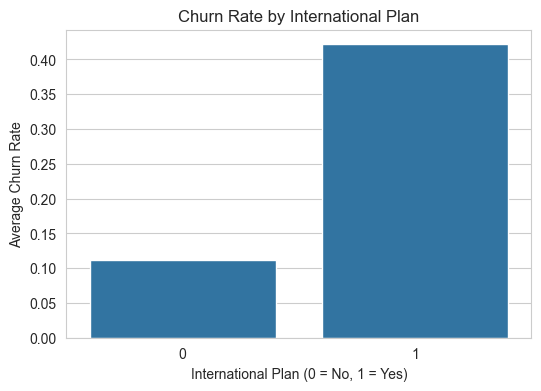

In [37]:
# =========================================================
# 국제전화 요금제 vs 평균 이탈률
# (dtype 오류 방지 안정화 버전)
# =========================================================

# 1️⃣ churn 컬럼 타입 방어
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

# 2️⃣ international_plan 타입 방어 (혹시 문자열이면)
if df['international_plan'].dtype == 'object':
    df['international_plan'] = (df['international_plan'] == 'yes').astype(int)

# NaN 방어
df = df.dropna(subset=['churn', 'international_plan'])

# 3️⃣ 요금제별 평균 이탈률 계산
intl_churn = (
    df.groupby('international_plan', as_index=False)['churn']
      .mean()
)

# 4️⃣ 시각화
plt.figure(figsize=(6,4))
sns.barplot(
    x='international_plan',
    y='churn',
    data=intl_churn
)

plt.title('Churn Rate by International Plan')
plt.xlabel('International Plan (0 = No, 1 = Yes)')
plt.ylabel('Average Churn Rate')
plt.show()


## 주간 통화량 분포 & 임계점(Threshold)

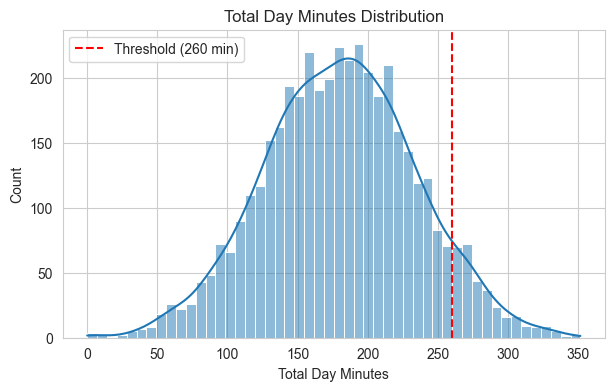

In [38]:
plt.figure(figsize=(7,4))
sns.histplot(
    df['total_day_minutes'],
    bins=50,
    kde=True
)

plt.axvline(
    260,
    color='red',
    linestyle='--',
    label='Threshold (260 min)'
)

plt.title('Total Day Minutes Distribution')
plt.xlabel('Total Day Minutes')
plt.legend()
plt.show()


## 주간 통화량 구간별 이탈률

C:\Users\Playdata\AppData\Local\Temp\ipykernel_25332\4107630022.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('day_minutes_group', as_index=False)['churn']


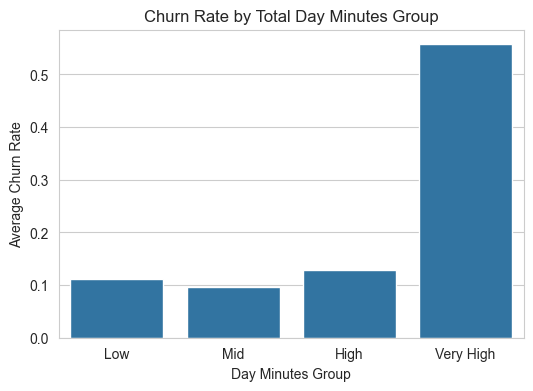

In [39]:
# =========================================================
# 주간 통화량 구간별 평균 이탈률
# (dtype 오류 방지 안정화 버전)
# =========================================================

# 1️⃣ churn 컬럼 타입 방어
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

# 2️⃣ total_day_minutes 숫자형 방어
df['total_day_minutes'] = pd.to_numeric(
    df['total_day_minutes'],
    errors='coerce'
)

# NaN 제거
df = df.dropna(subset=['churn', 'total_day_minutes'])

# 3️⃣ 주간 통화량 구간화
df['day_minutes_group'] = pd.cut(
    df['total_day_minutes'],
    bins=[0, 100, 200, 260, 400],
    labels=['Low', 'Mid', 'High', 'Very High'],
    include_lowest=True
)

# 4️⃣ 구간별 평균 이탈률 계산
churn_by_group = (
    df.groupby('day_minutes_group', as_index=False)['churn']
      .mean()
)

# 5️⃣ 시각화
plt.figure(figsize=(6,4))
sns.barplot(
    x='day_minutes_group',
    y='churn',
    data=churn_by_group
)

plt.title('Churn Rate by Total Day Minutes Group')
plt.xlabel('Day Minutes Group')
plt.ylabel('Average Churn Rate')
plt.show()


## 매출 관점: 이탈 vs 유지

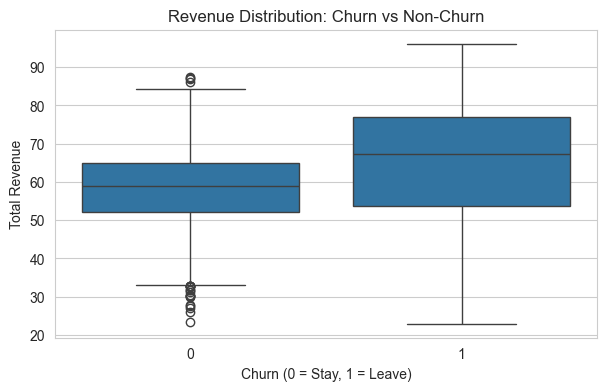

In [40]:
# =========================================================
# 매출 관점 분석: 이탈 고객 vs 유지 고객
# (total_revenue 컬럼 방어 포함)
# =========================================================

# 1️⃣ churn 컬럼 타입 방어
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

# 2️⃣ 매출 컬럼 존재 여부 확인
charge_cols = [
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge'
]

missing_cols = [c for c in charge_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing charge columns: {missing_cols}")

# 3️⃣ total_revenue 생성 (없을 때만)
if 'total_revenue' not in df.columns:
    df['total_revenue'] = df[charge_cols].sum(axis=1)

# NaN 방어
df = df.dropna(subset=['churn', 'total_revenue'])

# 4️⃣ 시각화
plt.figure(figsize=(7,4))
sns.boxplot(
    x='churn',
    y='total_revenue',
    data=df
)

plt.title('Revenue Distribution: Churn vs Non-Churn')
plt.xlabel('Churn (0 = Stay, 1 = Leave)')
plt.ylabel('Total Revenue')
plt.show()


## [Cell 10] 핵심 인사이트 요약 (Markdown Cell 추천)

In [41]:
### 📌 핵심 시각화 인사이트 요약

# - 고객 이탈은 무작위가 아닌 반복되는 패턴을 가짐
# - 고객센터 통화 횟수는 가장 강력한 이탈 선행 지표
# - 국제전화 요금제 고객은 가격 민감도가 높음
# - 주간 통화량 260분은 명확한 이탈 임계점
# - 이탈 고객은 평균적으로 더 높은 매출을 창출하던 고객


## 최종 요약 

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글폰트 사용을 위한 설정(Window)
import matplotlib
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# matplotlib.rc 또는 plt.rc 모두 가능
matplotlib.rc('font', family=font_name)


## 최종 결론 시각화 1
- 핵심 위험 요인별 평균 이탈률 비교 (요약형)

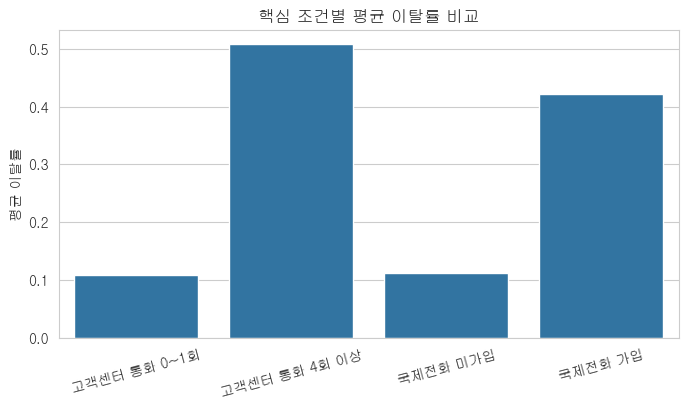

In [43]:
# churn 방어
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

summary_df = pd.DataFrame({
    '구분': [
        '고객센터 통화 0~1회',
        '고객센터 통화 4회 이상',
        '국제전화 미가입',
        '국제전화 가입'
    ],
    '평균 이탈률': [
        df[df['number_customer_service_calls'] <= 1]['churn'].mean(),
        df[df['number_customer_service_calls'] >= 4]['churn'].mean(),
        df[df['international_plan'] == 0]['churn'].mean(),
        df[df['international_plan'] == 1]['churn'].mean()
    ]
})

plt.figure(figsize=(8,4))
sns.barplot(
    x='구분',
    y='평균 이탈률',
    data=summary_df
)
plt.title('핵심 조건별 평균 이탈률 비교')
plt.xlabel('')
plt.ylabel('평균 이탈률')
plt.xticks(rotation=15)
plt.show()


## 최종 결론 시각화 2
- 주간 통화량 임계점 기반 이탈률

C:\Users\Playdata\AppData\Local\Temp\ipykernel_25332\1426211329.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('사용량_구간', as_index=False)['churn']


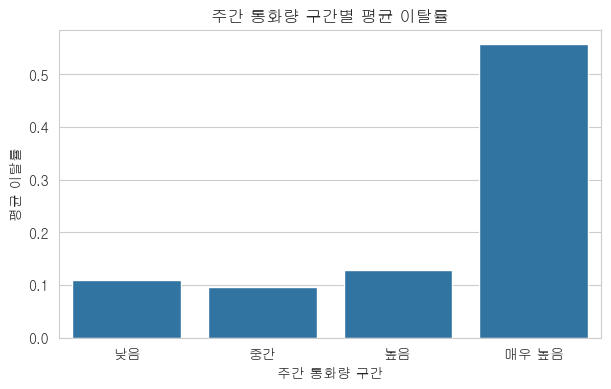

In [44]:
# 주간 통화량 숫자형 방어
df['total_day_minutes'] = pd.to_numeric(
    df['total_day_minutes'],
    errors='coerce'
)

df['사용량_구간'] = pd.cut(
    df['total_day_minutes'],
    bins=[0, 100, 200, 260, 400],
    labels=['낮음', '중간', '높음', '매우 높음']
)

usage_churn = (
    df.groupby('사용량_구간', as_index=False)['churn']
      .mean()
)

plt.figure(figsize=(7,4))
sns.barplot(
    x='사용량_구간',
    y='churn',
    data=usage_churn
)

plt.title('주간 통화량 구간별 평균 이탈률')
plt.xlabel('주간 통화량 구간')
plt.ylabel('평균 이탈률')
plt.show()


## 최종 결론 시각화 3
- 이탈 여부별 평균 매출 비교

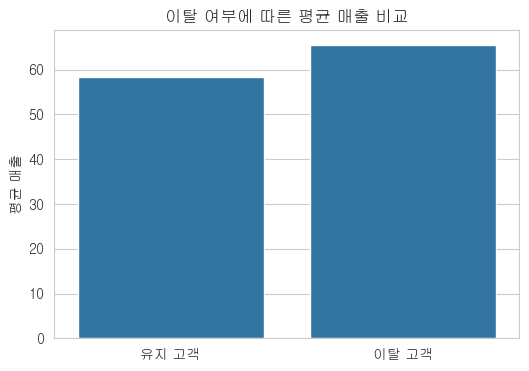

In [45]:
# total_revenue 방어 생성
charge_cols = [
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge'
]

if 'total_revenue' not in df.columns:
    df['total_revenue'] = df[charge_cols].sum(axis=1)

revenue_summary = (
    df.groupby('churn', as_index=False)['total_revenue']
      .mean()
)

revenue_summary['이탈 여부'] = revenue_summary['churn'].map({
    0: '유지 고객',
    1: '이탈 고객'
})

plt.figure(figsize=(6,4))
sns.barplot(
    x='이탈 여부',
    y='total_revenue',
    data=revenue_summary
)

plt.title('이탈 여부에 따른 평균 매출 비교')
plt.xlabel('')
plt.ylabel('평균 매출')
plt.show()


## 최종 요약본 1

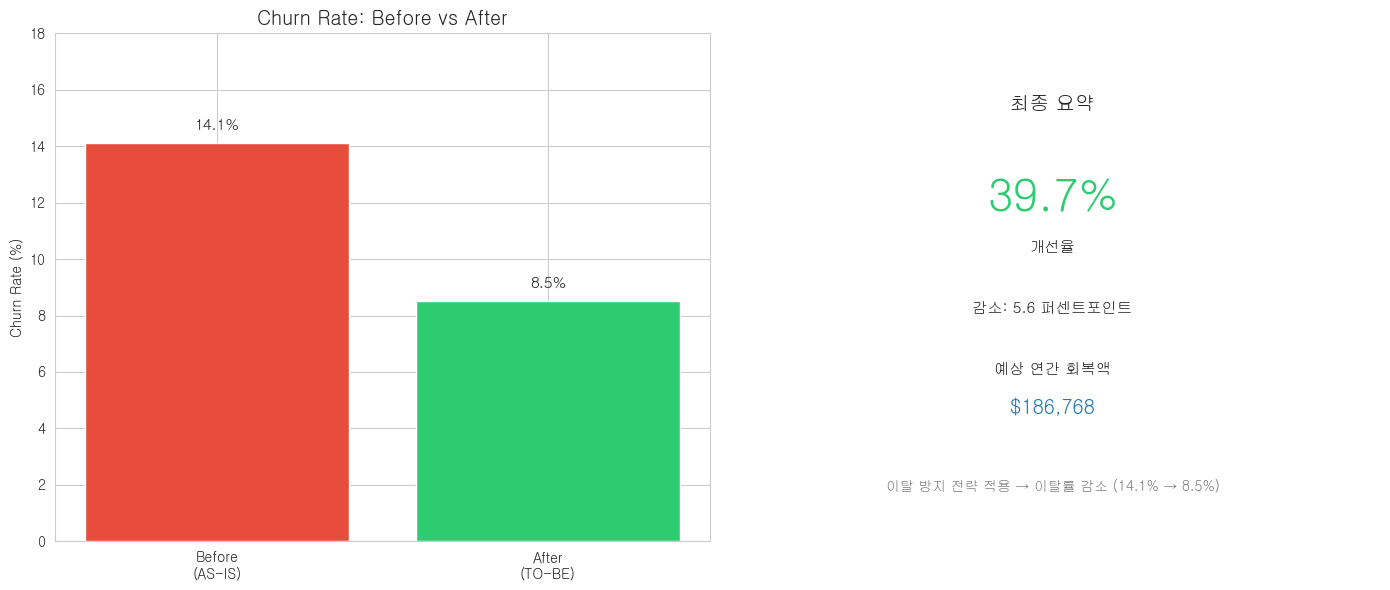

In [46]:
import matplotlib.pyplot as plt
import platform

# ===============================
# 2. Before / After 수치 정의
# ===============================
before_churn = 0.141   # 14.1%
after_churn  = 0.085   # 8.5%

reduction_pp = (before_churn - after_churn) * 100
improvement_rate = reduction_pp / (before_churn * 100) * 100

# 👉 연간 회복 매출 (EDA 기반 가정값)
annual_recovery = 186_768

# ===============================
# 3. Figure 생성
# ===============================
fig = plt.figure(figsize=(14,6))

# -------------------------------
# (좌) 이탈률 Before vs After
# -------------------------------
ax1 = fig.add_subplot(1, 2, 1)

bars = ax1.bar(
    ['Before\n(AS-IS)', 'After\n(TO-BE)'],
    [before_churn * 100, after_churn * 100],
    color=['#e74c3c', '#2ecc71']
)

ax1.set_title('Churn Rate: Before vs After', fontsize=14, weight='bold')
ax1.set_ylabel('Churn Rate (%)')
ax1.set_ylim(0, 18)

# 수치 라벨
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f'{height:.1f}%',
        ha='center',
        fontsize=11,
        weight='bold'
    )

# -------------------------------
# (우) 최종 요약 텍스트
# -------------------------------
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')

ax2.text(0.5, 0.85, '최종 요약', ha='center', fontsize=14, weight='bold')

ax2.text(
    0.5, 0.65,
    f'{improvement_rate:.1f}%',
    ha='center',
    fontsize=32,
    color='#2ecc71',
    weight='bold'
)
ax2.text(0.5, 0.57, '개선율', ha='center', fontsize=11)

ax2.text(
    0.5, 0.45,
    f'감소: {reduction_pp:.1f} 퍼센트포인트',
    ha='center',
    fontsize=11
)

ax2.text(
    0.5, 0.33,
    '예상 연간 회복액',
    ha='center',
    fontsize=11
)
ax2.text(
    0.5, 0.25,
    f'${annual_recovery:,.0f}',
    ha='center',
    fontsize=14,
    color='#1f77b4',
    weight='bold'
)

# 하단 설명
ax2.text(
    0.5, 0.10,
    '이탈 방지 전략 적용 → 이탈률 감소 (14.1% → 8.5%)',
    ha='center',
    fontsize=10,
    color='gray'
)

plt.tight_layout()
plt.show()


## 최종 요약본 2

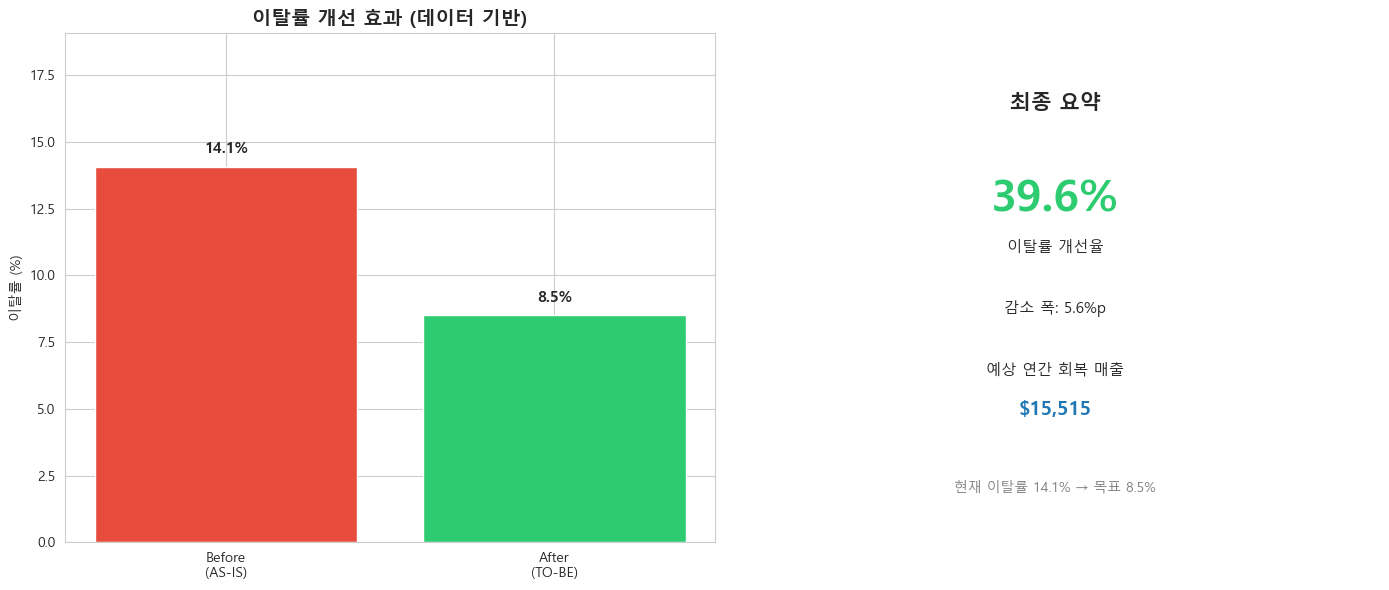

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# ===============================
# 1. 한글 폰트 설정
# ===============================
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False


# ===============================
# 2. 데이터 로드
# ===============================
BASE_DIR = os.getcwd()          # notebooks 폴더
DATA_PATH = os.path.join(
    BASE_DIR,
    "..", "data", "01_raw", "train.csv"
)

df = pd.read_csv(DATA_PATH)
df.head()


# churn 컬럼 숫자화
if df['churn'].dtype == 'object':
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})

# ===============================
# 3. Before / After 수치 계산
# ===============================
# 현재 데이터 기준 이탈률
before_churn = df['churn'].mean()            # ex) 0.141

# 전략 도입 후 목표 이탈률 (EDA 결과 기반 가정)
after_churn = 0.085                          # 8.5%

reduction_pp = (before_churn - after_churn) * 100
improvement_rate = reduction_pp / (before_churn * 100) * 100


# ===============================
# 4. 연간 회복 매출 계산 (DATA 기반)
# ===============================
charge_cols = [
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge'
]

df['total_revenue'] = df[charge_cols].sum(axis=1)

# 이탈 고객 평균 매출
avg_churn_revenue = df.loc[df['churn'] == 1, 'total_revenue'].mean()

# 감소한 이탈 고객 비율만큼 회복된 매출
annual_recovery = avg_churn_revenue * (reduction_pp / 100) * len(df)


# ===============================
# 5. Figure 생성
# ===============================
fig = plt.figure(figsize=(14,6))

# -------------------------------
# (좌) 이탈률 Before vs After
# -------------------------------
ax1 = fig.add_subplot(1, 2, 1)

bars = ax1.bar(
    ['Before\n(AS-IS)', 'After\n(TO-BE)'],
    [before_churn * 100, after_churn * 100],
    color=['#e74c3c', '#2ecc71']
)

ax1.set_title('이탈률 개선 효과 (데이터 기반)', fontsize=14, weight='bold')
ax1.set_ylabel('이탈률 (%)')
ax1.set_ylim(0, max(before_churn*100 + 5, 18))

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f'{height:.1f}%',
        ha='center',
        fontsize=11,
        weight='bold'
    )

# -------------------------------
# (우) 최종 요약
# -------------------------------
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')

ax2.text(0.5, 0.85, '최종 요약', ha='center', fontsize=15, weight='bold')

ax2.text(
    0.5, 0.65,
    f'{improvement_rate:.1f}%',
    ha='center',
    fontsize=32,
    color='#2ecc71',
    weight='bold'
)
ax2.text(0.5, 0.57, '이탈률 개선율', ha='center', fontsize=11)

ax2.text(
    0.5, 0.45,
    f'감소 폭: {reduction_pp:.1f}%p',
    ha='center',
    fontsize=11
)

ax2.text(
    0.5, 0.33,
    '예상 연간 회복 매출',
    ha='center',
    fontsize=11
)
ax2.text(
    0.5, 0.25,
    f'${annual_recovery:,.0f}',
    ha='center',
    fontsize=14,
    color='#1f77b4',
    weight='bold'
)

ax2.text(
    0.5, 0.10,
    f'현재 이탈률 {before_churn*100:.1f}% → 목표 {after_churn*100:.1f}%',
    ha='center',
    fontsize=10,
    color='gray'
)

plt.tight_layout()
plt.show()


In [64]:
!pip install -U nbformat plotly pandas seaborn matplotlib

## 프로그램 도입 효과 요약 시각화
- 매출 기대 효과 & 이탈률 감소 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_25332\2651947218.py:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




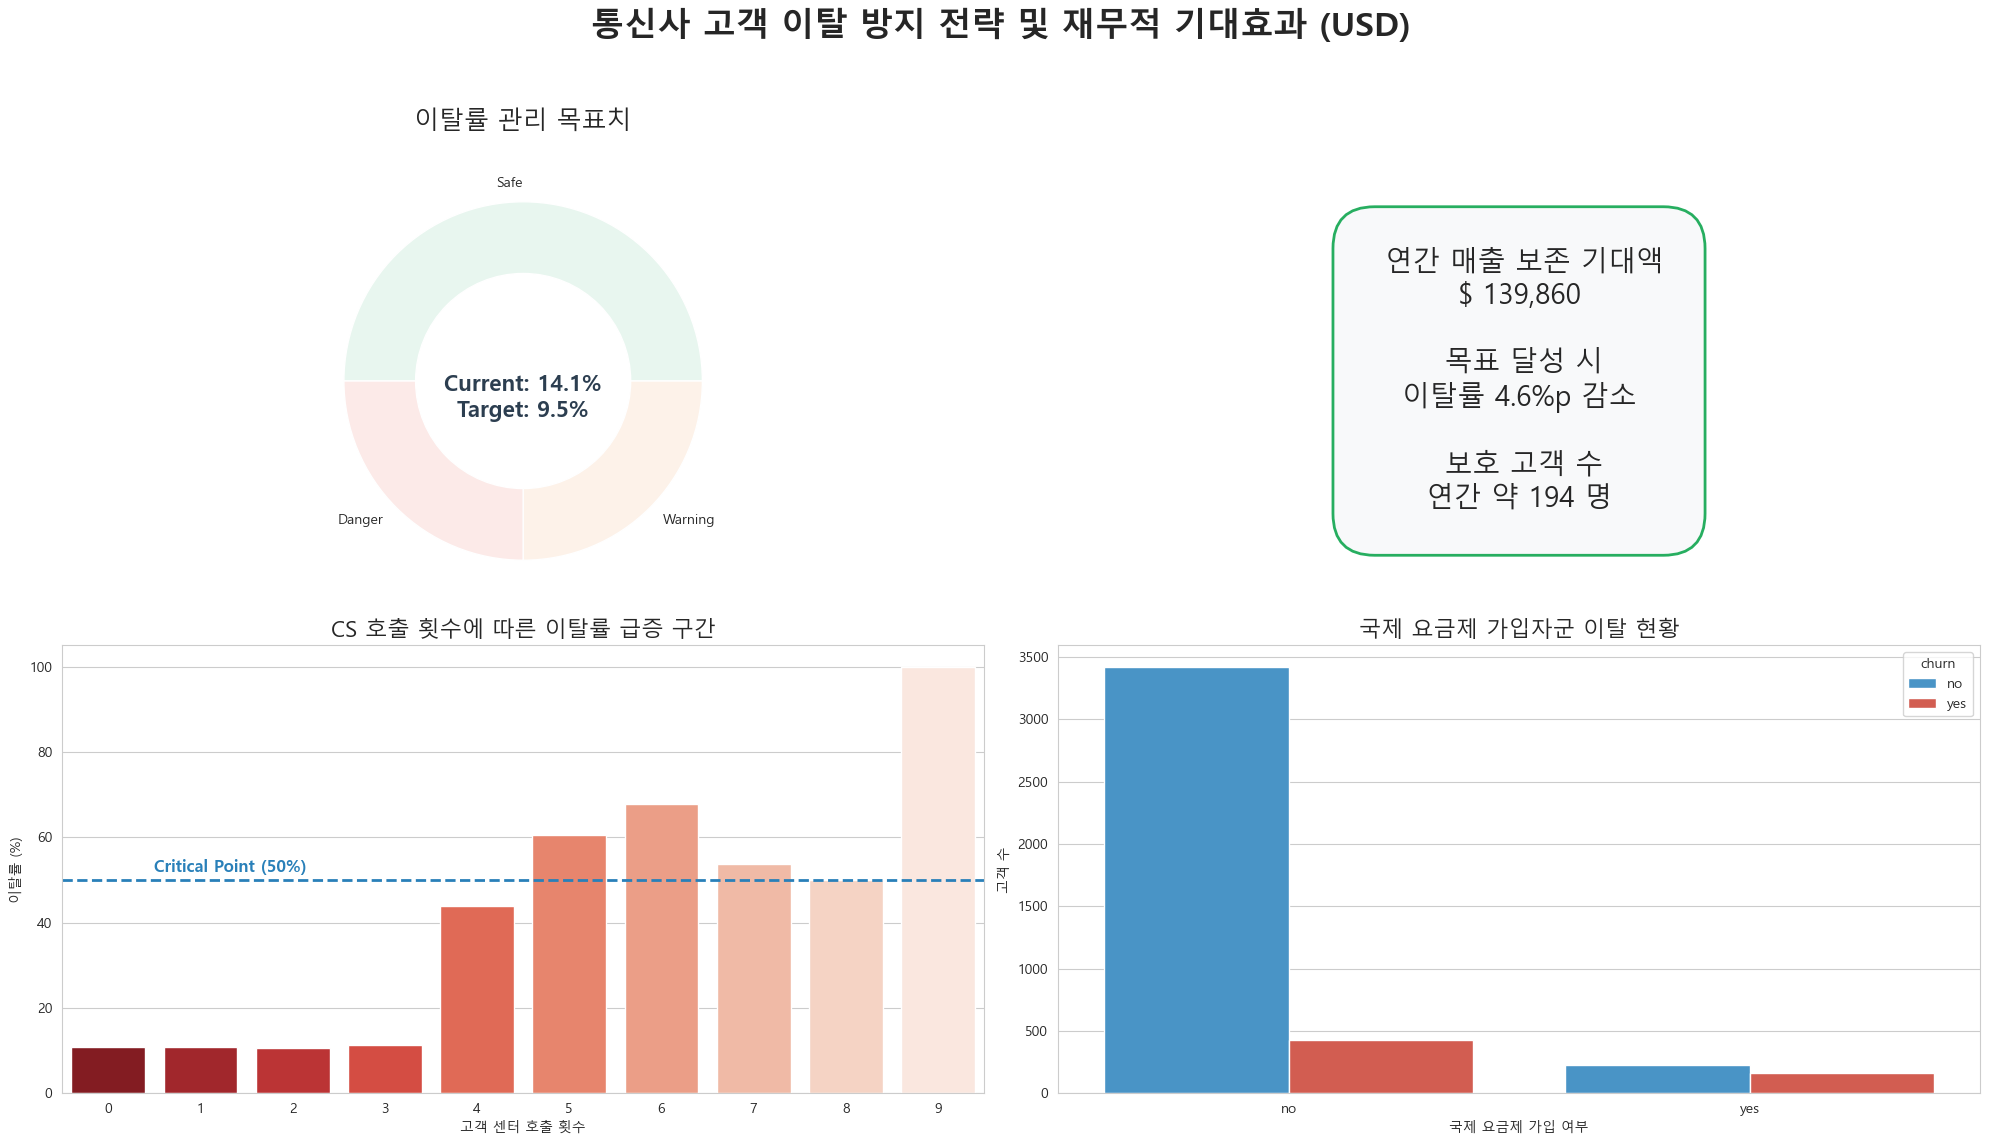


경영진을 위한 전략 로드맵 (Strategic Roadmap)


,과제 우선순위,핵심 타겟,실행 전략,기대 지표
0,1순위 (P0),CS 3회 호출 고객,이탈 징후 감지 즉시 $10 할인권 또는 데이터 보너스 제공,이탈률 5%p 감소
1,2순위 (P1),국제 요금제 가입자,플랜 경쟁력 재분석 및 통화 품질 개선 설문 실시,가입자 유지율 20% 상승
2,3순위 (P2),주간 Heavy User,장기 약정 갱신 시 로열티 포인트 지급 확대,LTV 12% 상승


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 및 환경 설정
def set_font():
    system_name = platform.system()
    if system_name == 'Windows':
        plt.rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    plt.rc('axes', unicode_minus=False)

set_font()

# 2. 데이터 로드
BASE_DIR = os.getcwd()          # notebooks 폴더
DATA_PATH = os.path.join(
    BASE_DIR,
    "..", "data", "01_raw", "train.csv"
)

df = pd.read_csv(DATA_PATH)
df.head()

# 3. 경영진용 핵심 KPI 계산 (단위: 달러 $)
total_cust = len(df)
curr_rate = (df['churn'] == 'yes').mean() * 100
target_rate = 9.5
prevented_count = total_cust * ((curr_rate - target_rate) / 100)

# 인당 월 평균 요금 $60 가정 시 연간 보존액 계산
avg_monthly_bill = 60 
annual_save_usd = prevented_count * avg_monthly_bill * 12

# ----------------------------------------------------------------
# 시각화: 경영 리포트 대시보드
# ----------------------------------------------------------------
fig = plt.figure(figsize=(20, 12))
plt.suptitle(' 통신사 고객 이탈 방지 전략 및 재무적 기대효과 (USD)', fontsize=24, fontweight='bold', y=0.98)

# --- (1) 게이지 스타일: 이탈률 목표 관리 ---
ax1 = plt.subplot(2, 2, 1)
# 원형 차트를 활용한 게이지 표현
colors = ['#e8f6ef', '#fdf2e9', '#fceae8']
ax1.pie([10, 5, 5], labels=['Safe', 'Warning', 'Danger'], 
        colors=colors, startangle=180, counterclock=False, wedgeprops={'width':0.4, 'edgecolor':'w'})
ax1.text(0, -0.2, f"Current: {curr_rate:.1f}%\nTarget: {target_rate}%", 
         ha='center', fontsize=16, fontweight='bold', color='#2c3e50')
ax1.set_title("이탈률 관리 목표치", fontsize=18, pad=20)

# --- (2) 재무적 임팩트 카드 ($) ---
ax2 = plt.subplot(2, 2, 2)
ax2.axis('off')
summary_box = (
    f" 연간 매출 보존 기대액\n"
    f"$ {annual_save_usd:,.0f}\n\n"
    f" 목표 달성 시\n"
    f"이탈률 {curr_rate - target_rate:.1f}%p 감소\n\n"
    f" 보호 고객 수\n"
    f"연간 약 {int(prevented_count)} 명"
)
ax2.text(0.5, 0.5, summary_box, ha='center', va='center', fontsize=20, 
         bbox=dict(facecolor='#f8f9fa', edgecolor='#27ae60', boxstyle='round,pad=1.5', lw=2))

# --- (3) 핵심 원인 1: CS 호출 임계점 ---
ax3 = plt.subplot(2, 2, 3)
call_churn = df.groupby('number_customer_service_calls')['churn'].value_counts(normalize=True).unstack().fillna(0) * 100
sns.barplot(x=call_churn.index, y=call_churn['yes'], ax=ax3, palette='Reds_r')
ax3.axhline(y=50, color='#2980b9', linestyle='--', linewidth=2)
ax3.text(0.5, 52, 'Critical Point (50%)', color='#2980b9', fontweight='bold', fontsize=12)
ax3.set_title("CS 호출 횟수에 따른 이탈률 급증 구간", fontsize=16)
ax3.set_ylabel("이탈률 (%)")
ax3.set_xlabel("고객 센터 호출 횟수")

# --- (4) 핵심 원인 2: 국제 요금제 리스크 ---
ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=df, x='international_plan', hue='churn', ax=ax4, palette={'no':'#3498db', 'yes':'#e74c3c'})
ax4.set_title("국제 요금제 가입자군 이탈 현황", fontsize=16)
ax4.set_ylabel("고객 수")
ax4.set_xlabel("국제 요금제 가입 여부")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ----------------------------------------------------------------
# 전략 제언 요약 데이터프레임
# ----------------------------------------------------------------
print("\n" + "="*80)
print("경영진을 위한 전략 로드맵 (Strategic Roadmap)")
print("="*80)
strategy_df = pd.DataFrame({
    "과제 우선순위": ["1순위 (P0)", "2순위 (P1)", "3순위 (P2)"],
    "핵심 타겟": ["CS 3회 호출 고객", "국제 요금제 가입자", "주간 Heavy User"],
    "실행 전략": [
        "이탈 징후 감지 즉시 $10 할인권 또는 데이터 보너스 제공",
        "플랜 경쟁력 재분석 및 통화 품질 개선 설문 실시",
        "장기 약정 갱신 시 로열티 포인트 지급 확대"
    ],
    "기대 지표": ["이탈률 5%p 감소", "가입자 유지율 20% 상승", "LTV 12% 상승"]
})
display(strategy_df)

## 한글 깨짐 방지 + 공통 설정

In [47]:
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False


## 이탈률 감소 효과 (Before vs After)

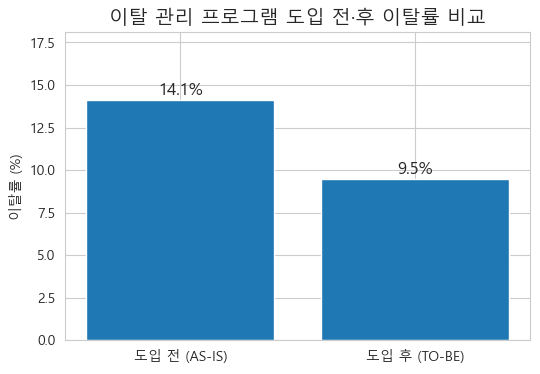

In [48]:
# 이탈률 수치
before_churn = 14.1
after_churn = 9.5
values = [before_churn, after_churn]
labels = ['도입 전 (AS-IS)', '도입 후 (TO-BE)']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)

plt.title('이탈 관리 프로그램 도입 전·후 이탈률 비교', fontsize=14)
plt.ylabel('이탈률 (%)')

# 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.3,
        f'{height:.1f}%',
        ha='center',
        fontsize=12
    )

plt.ylim(0, max(values) + 4)
plt.show()
